__TU Graz__ - Foundations of Computational Social Systems - W2022
## __Project: Sentiment analysis on Steam Games__

***
#### __Project description__

In this project we analyse the relations between the sentiments of game reviews on the gaming platform Steam. To access data on Steam we use the official RESTful Steam API. Some services require a web-key which is only available with an active Steam account. The description to activate the web-key can found here: https://steamcommunity.com/dev

> IMPORTANT: After activation you need to insert the key to the constant 'STEAM_WEB_API_KEY' in the configuration section [Configuration constants](####configuration-constants) 

__Our Hypotheses__

* H1: There is a positive correlation between the sentiment of the reviews and the review-score of each game.
* H2: There is a positive correlation between the sentiment of each review and its perceived helpfulness by the community.
* H3: Reviews that recommend the game are more positive in their sentiment than reviews that do not recommend the game.

__Step by step plan__

Here are the steps that should give an overview of what this notebook does: 
1. Request all games (name and appid) from the Steam using its API
2. For every game we retrieve its most helpful 100 reviews
3. For every game:
    * Perform sentiment analysis on every single review (We use VADER to perform sentiment analysis)
4. Statistical analysis

***
#### __File and Folder structure__
- __FOLDER: sentiment__
    - One file for one game. Every file contains the sentiment scores of 100 reviews. 
    - Filename: [appid].pkl
- __FOLDER: reviews__
    - One file for one game. Every file contains game infos and at least 100 reviewdata.
    - Filename: [appid].pkl
- __FILE: irrelevant_apps.pkl__
    - For a container that represents all games that are not relevant
    - Consits of one big dictionary which keys are the appid and information of why this game is irrelevant for our analysis. 
- __FILE: games.pkl__
- __FILE: all_reviews.pkl__
- __FILE: all_games.pkl__

***
#### __Contents of this Notebook__
> [Setup](###setup) > [Required modules](####required-modules) > [Configuration constants](####configuration-constants) > [Steam API functionality](####steam-api-functionality)


* [1 Download Data](#1-download-data)
    * [1.1 Download games data](#11-get-all-steam-games-and-filter-for-relevance)
    * [1.2 Download game reviews](#12-get-reviews-of-each-game)
* [2 Sentiment Analysis](#2-sentiment-analysis)
* [3 Data Processing](#3-process-data)
* [4 Statistical Analysis](#4-statistical-analysis)
    * [4.1 Hypothesis H1](#41-hypothesis-h1)
    * [4.2 Hypothesis H2](#42-hypothesis-h2)
    * [4.3 Hypothesis H3](#43-hypothesis-h3)
* [5 Conclusions](#5-conclusions)

***
[< back to contents](#contents-of-this-notebook)
### __Setup__

#### __Required modules__

In [ ]:
! pip install vaderSentiment
! pip install pandas
! pip install pickle

In [1]:
import requests
from requests.exceptions import HTTPError
import json
import urllib.parse
import pandas as pd
import pickle
from os import path, mkdir
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

#### __Configuration constants__

In [2]:
# The Steam web key needs to be set here:
STEAM_WEB_API_KEY = '#########################'

# General settings:
NEEDED_NUM_REVIEWS_PER_GAME = 100
REVIEWS_DIR = 'reviews'
SENTIMENT_DIR = 'sentiment'

# Stages:
ALREADY_DOWNLOADED_REVIEWS = True
ALREADY_DOWNLOADED_GAMES = True
ALREADY_PERFORMED_SENTIMENT_ANALYSIS = True
ALREADY_COMBINED_DATASETS = True

#### __Steam API Functionality__

In [3]:
def dict_to_string(dictionary:dict) -> str:
    '''
    The Steam API allows json formatted variables in the url
    This is a helper function for this functionality
    '''
    string_elements = []
    for (key, value) in dictionary.items():
        string_elements.append(f"{key}: {dict_to_string(value) if isinstance(value, dict) else str(value)}")
    return "{%s}"%", ".join(string_elements)

def request_resource(api_url:str, url_args:dict, show_output:bool=True, retries=10) -> dict|None:
    '''
    Download json data from a given url + its arguments
    Return None if some error happened
    '''
    if show_output: print(f"REQUEST TO {api_url} args {url_args}")
    payload = None
    while retries > 0:
        try:
            response = requests.get(api_url, params=url_args)
            response.raise_for_status
            #response.encoding = 'utf-8'
            payload = response.json()
        except HTTPError as http_err:
            print(f"HTTP error occurred: {http_err}")
        except ValueError as err:
            print(f"Payload is not json: {err}")
        except Exception as err:
            print(f"Other error occurred: {err}")  
        else:
            if show_output:
                print(' => Success!')
                break  
        retries -= 1
    return payload

# ============== Steam API service functionality ================

def download_steam_applist() -> dict:
    '''
    Collects all applications available on Steam (includes everything)
    List of appids and according application titles
    '''
    api_url = 'https://api.steampowered.com/ISteamApps/GetAppList/v2/'
    args = {}
    apps = request_resource(api_url, args)
    return apps if apps is not None else dict()

def download_steam_games() -> pd.DataFrame:
    '''
    Collects all relevant Steam games (only gaming software, no DLCs)
    List of appids and according game titles
    '''
    api_url = "https://api.steampowered.com/IStoreService/GetAppList/v1"
    args = {
        'key': STEAM_WEB_API_KEY,
        'have_description_language' : 'english',
        'include_games': True,
        'include_dlc' : False,
        'include_software' : False,
        'include_videos' : False,
        'include_hardware' : False,
        'max_results' : 50000
    }
    apps = []
    have_more_results = True
    while have_more_results:
        data = request_resource(api_url, args, show_output=False)
        if data == None: break
        data = data['response']
        apps += [{'appid': app['appid'], 'name': app['name']} for app in data['apps']]
        
        # have_more_results indicates that there are more pages
        # last_appid functions like the page index for the next page
        # if there are no more apps (=we are on the last page)
        if 'have_more_results' not in data or 'last_appid' not in data: break
        have_more_results = data['have_more_results']
        args['last_appid'] = data['last_appid']
    return pd.DataFrame(apps)

def download_steam_reviews_of_game(gameid: int, min_num_reviews: int, show_output: bool=True) -> dict|None:
    '''
    Collects a minimum number of reviews of a given gameid(=appid) on the Steam store.
    Return a dictionary that contains the games review score, data of its reviews
    STEAMWORKS documentation: https://partner.steamgames.com/doc/store/getreviews
    '''
    api_url = "http://store.steampowered.com/appreviews/" + str(gameid)
    args = {
        'json': 1,
        'filter': 'all',
        'language': 'english',
        'day_range': 365,
        'cursor': '*',
        'review_type': 'all',
        'purchase_type': 'all'
    }
    STEAM_API_MAX_NUM_REVIEWS_PER_PAGE = 100

    # First query for game rating information and the first chunk of reviews
    data = request_resource(api_url, args, show_output=show_output)
    if data is None or data['success'] == 0: 
        return None
    query_summary = data['query_summary']
    game_reviews = {
        'review_score' : query_summary['review_score'],
        'total_positive' : query_summary['total_positive'],
        'total_negative' : query_summary['total_negative'],
        'total_reviews' : query_summary['total_reviews'],
        'num_reviews' : 0,
        'reviews' : []
    }
    prev_cursors = []
    cursor = data['cursor']
    args['num_per_page'] = STEAM_API_MAX_NUM_REVIEWS_PER_PAGE

    while True:
        # Get review texts
        game_reviews['reviews'] += [{
                'text' : review['review'], 
                'weighted_vote_score' : review['weighted_vote_score'],
                'voted_up' : review['voted_up'],
                'votes_up' : review['votes_up'],
                'votes_funny' : review['votes_funny']
            } for review in data['reviews']]
        game_reviews['num_reviews'] += len(data['reviews'])
        if game_reviews['num_reviews'] >= min_num_reviews: 
            break

        # Update cursor for pagination
        if cursor in prev_cursors: 
            break
        prev_cursors.append(cursor)
        cursor = data['cursor'].encode()
        args['cursor'] = cursor

        # Get next page
        data = request_resource(api_url, args, show_output=show_output)
        if data is None or data['success'] == 0: 
            break
    return game_reviews

[< back to contents](####contents-of-this-notebook)
***
## 1 Download data 
### 1.1 Get all steam games and filter for relevance

Download a list with all relevant games on Steam

In [3]:
def get_all_games() -> pd.DataFrame:
    '''
    Returns a dataframe that contains all Steam games. 
    If the data was already downloaded the dataframe is loaded from storage otherwise freshly downloaded.
    '''
    def _load_games() -> pd.DataFrame:
        return pd.read_pickle("games.pkl")

    def _save_games(games:pd.DataFrame) -> None:
        games.to_pickle("games.pkl")

    if ALREADY_DOWNLOADED_GAMES:
        print("Loading games from disk")
        return _load_games()
    else:
        print("Downloading games from steam")
        df = download_steam_games()
        _save_games(df)
        return df

df_all_games = get_all_games()
display(df_all_games)

Loading games from disk


,appid,name
0,10,Counter-Strike
1,20,Team Fortress Classic
2,30,Day of Defeat
3,40,Deathmatch Classic
4,50,Half-Life: Opposing Force
...,...,...
76798,2246840,A Desert Christmas Story
76799,2246880,STANDBOX
76800,2247360,Little Porp
76801,2247490,Stepmom


### 1.2 Get reviews of each game 

Utility functions to help with saving and loading game reviews

In [6]:
def create_dir_if_not_exists(folder_name:str) -> None:
    if not path.exists(folder_name):
        mkdir(folder_name)

def log_error(error_line:str) -> None:
    with open("error_log.txt", "a+") as f:
        f.write(error_line + "\n")

def reviews_retrieved(appid:int) -> bool:
    return path.exists(f"{REVIEWS_DIR}/{appid}.pkl")

def save_reviews(appid:int, review_data:dict) -> None:
    file_path = f"{REVIEWS_DIR}/{appid}.pkl"
    with open(file_path, "wb") as f:
        pickle.dump(review_data, f)

def load_reviews(appid:int) -> dict:
    review = dict()
    file_path = f"{REVIEWS_DIR}/{appid}.pkl"
    with open(file_path, "rb") as f:
        review = pickle.load(f)
    return review

def load_irrelevant_games() -> dict:
    appids = dict()
    file_path = "irrelevant_apps.pkl"
    if path.exists(file_path):
        with open(file_path, "rb") as f:
            appids = pickle.load(f)
    return appids
    
def is_irrelevant_game(appid:int, review_data:dict, irrelevant_games:dict) -> bool:
    '''
    A game is irrelevant if it does not have at least NEEDED_NUM_REVIEWS_PER_GAME reviews
    '''
    # Not sure if this is really that good tbh
    def _save_irrelevant_games(appids:dict) -> None:
        file_path = "irrelevant_apps.pkl"
        with open(file_path, "wb+") as f:
            pickle.dump(appids, f)
    # Criterions of game reviews to be relevant
    error_msg = ""
    error_happened = False
    if review_data is None:
        error_msg = "reviews could not be retrieved"
        error_happened = True
    elif review_data['num_reviews'] < NEEDED_NUM_REVIEWS_PER_GAME:
        error_msg = f"{review_data['num_reviews']} reviews"
        error_happened = True
    if error_happened:
        irrelevant_games[appid] = error_msg
        _save_irrelevant_games(irrelevant_games)
        print(" - ", appid, error_msg)
        return True
    return False

Download reviews of all relevant games

In [5]:
if not ALREADY_DOWNLOADED_REVIEWS:
    irrelevant_games = load_irrelevant_games()
    num_games = df_all_games.shape[0]
    num_processed_games = 0

    for appid in df_all_games['appid']:
        if reviews_retrieved(appid) or appid in irrelevant_games:
            continue

        review_data = download_steam_reviews_of_game(appid, min_num_reviews=NEEDED_NUM_REVIEWS_PER_GAME, show_output=False)
        if is_irrelevant_game(appid, review_data, irrelevant_games):
            continue
        
        save_reviews(appid, review_data)
        num_processed_games += 1
        print(num_processed_games, "/", num_games, ":", appid, "processed")

[< back to contents](####contents-of-this-notebook)
***
## 2 Sentiment Analysis
#### 2.1 Perform sentiment analysis on each review of every game

Utility functions for sentiment analysis

In [5]:
def sentiments_retrieved(appid:int) -> bool:
    file_path = f"{SENTIMENT_DIR}/{appid}.pkl"
    return path.exists(file_path)

def save_sentiments(appid:int, df:pd.DataFrame) -> None:
    file_path = f"{SENTIMENT_DIR}/{appid}.pkl"
    create_dir_if_not_exists(SENTIMENT_DIR)
    df.to_pickle(file_path)

def load_sentiments(appid:int) -> pd.DataFrame:
    file_path = f"{SENTIMENT_DIR}/{appid}.pkl"
    if path.exists(file_path):
        df = pd.read_pickle(file_path)
        assert isinstance(df, pd.DataFrame)
        return df
    return pd.DataFrame()

For sentiment analysis we use **VADER**. According to its documentation the compound score means:
* 'compound' >= 0.05 : 'Positive'
* 'compound' <= -0.05 : 'Negative'
* else : 'Neutral'

Perform sentiment analysis on the reviews of every game

In [7]:
if not ALREADY_PERFORMED_SENTIMENT_ANALYSIS:
    
    analyser = SentimentIntensityAnalyzer()

    for appid in df_all_games['appid']:

        if sentiments_retrieved(appid) or not reviews_retrieved(appid):
            continue
        
        print("analysing", appid)
        game_reviews = load_reviews(appid)
        df_game_reviews = pd.DataFrame(game_reviews['reviews']).loc[0:NEEDED_NUM_REVIEWS_PER_GAME-1]
        if df_game_reviews.shape[0] < NEEDED_NUM_REVIEWS_PER_GAME: # should not happen at this stage!
            log_error(f"{appid}: not enough reviews for sentiment analysis")
            continue
        
        sentiments = [analyser.polarity_scores(text) for text in df_game_reviews['text']]
        df_sentiments = pd.DataFrame(sentiments)
        save_sentiments(appid, df_sentiments)

[< back to contents](####contents-of-this-notebook)
***
## 3 Process data

Generate two big dataframes:
1. with all relevant informations of the selected games with the mean sentiment scores of its reviews
2. all downloaded reviews with the according sentiment scores 

In [3]:
def get_games_and_reviews() -> tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Combines the downloaded data with the calculated sentiments scores into two dataframes
    Returns:
        1. dataframe: games with mean sentiments scores (calculated out of review sentiments)
        2. dataframe: all downloaded reviews with according sentiment scores
    '''
    def _load_game_review_sentiment_data() -> tuple[pd.DataFrame, pd.DataFrame]:
        return (pd.read_pickle("all_games.pkl"), pd.read_pickle("all_reviews.pkl"))

    def _combine_game_review_sentiment_data() -> tuple[pd.DataFrame, pd.DataFrame]:
        reviews_list = []
        games_list = []

        for appid in df_all_games['appid']:
            if not sentiments_retrieved(appid) or not reviews_retrieved(appid):
                continue
            
            df_sentiments = load_sentiments(appid)
            game_review_data = load_reviews(appid)

            games_list.append({
                'appid' : appid,
                'review_score' : game_review_data['review_score'],
                'sent.mean_pos' : df_sentiments['pos'].mean(),
                'sent.mean_neg' : df_sentiments['neg'].mean(),
                'sent.mean_neu' : df_sentiments['neu'].mean(),
                'sent.mean_comp' : df_sentiments['compound'].mean()
            })
            
            for review_id in range(NEEDED_NUM_REVIEWS_PER_GAME):
                review = game_review_data['reviews'][review_id]
                sentiment = df_sentiments.iloc[review_id]
                reviews_list.append({
                    'appid' : appid,
                    'reviewid' : review_id,
                    'text' : review['text'],
                    'weighted_vote_score' : review['weighted_vote_score'],
                    'voted_up' : review['voted_up'],
                    'votes_up' : review['votes_up'],
                    'sent.pos' : sentiment['pos'],
                    'sent.neg' : sentiment['neg'],
                    'sent.neu' : sentiment['neu'],
                    'sent.comp' : sentiment['compound']
                })

        df_games = pd.DataFrame(games_list)
        df_reviews = pd.DataFrame(reviews_list)
        df_games.to_pickle("all_games.pkl")
        df_reviews.to_pickle("all_reviews.pkl")
        return (df_games, df_reviews)

    if ALREADY_COMBINED_DATASETS:
        print("Loading from disk")
        return _load_game_review_sentiment_data()
    else:
        print("Combining data into dataframes")
        return _combine_game_review_sentiment_data()

# Generate final dataframes
df_games, df_reviews = get_games_and_reviews()
df_reviews['weighted_vote_score'] = df_reviews['weighted_vote_score'].astype(float)

# Print for quick inspection
num_games, num_reviews = df_games.shape[0], df_reviews.shape[0]
assert num_reviews == num_games*NEEDED_NUM_REVIEWS_PER_GAME
print("games:", num_games)
print("reviews:", num_reviews)
display("df_games", df_games.head())
display("df_reviews", df_reviews.head())

Loading from disk
games: 22045
reviews: 2204500


'df_games'

,appid,review_score,sent.mean_pos,sent.mean_neg,sent.mean_neu,sent.mean_comp
0,10,9,0.27963,0.04258,0.66780,0.318194
1,20,8,0.18169,0.07878,0.71952,0.225828
2,30,8,0.32749,0.07685,0.59565,0.327002
3,40,8,0.21444,0.10637,0.67925,0.335279
4,50,9,0.18644,0.06789,0.74569,0.297273


'df_reviews'

,appid,reviewid,text,weighted_vote_score,voted_up,votes_up,sent.pos,sent.neg,sent.neu,sent.comp
0,10,0,Sometimes you will never know the value of a m...,0.912457,True,110,0.000,0.127,0.873,-0.2584
1,10,1,One of the best games of our childhood. I don'...,0.902938,True,135,0.418,0.000,0.582,0.9442
2,10,2,Players who's still play this game:\n⣿⣿⣿⣿⣿⣿⣿⣿⡿...,0.883803,True,105,0.074,0.000,0.926,0.3400
3,10,3,joining a server is like russian roulette,0.879243,True,84,0.294,0.000,0.706,0.3612
4,10,4,people who still play this game\n⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⠛⠛...,0.869217,True,116,0.074,0.000,0.926,0.3400


[< back to contents](####contents-of-this-notebook)
***
# 4 Statistical Analysis

Now we want to test our hypotheses

* H1: There is a positive correlation between the sentiment of the reviews and the review-score of each game.
* H2: There is a positive correlation between the sentiment of each review and its perceived helpfulness by the community.
* H3: Reviews that recommend the game are more positive in their sentiment than reviews that do not recommend the game.

## 4.1 Hypothesis H1

> There is a positive correlation between the _**sentiment of the reviews**_ and the _**review-score**_ of each game.

In [4]:
H1_coeff, H1_p_value = stats.pearsonr(df_games['sent.mean_comp'], df_games['review_score'])
print("Correlation:", H1_coeff)
print("P-value:", H1_p_value)

Correlation: 0.5215793161444982
P-value: 0.0


Investigate the p-values not showing more decimals. 
Conclusion: 0.0 is smaller than 0.001 => very significant.

In [25]:
test_values = {'sample_count':[], 'coefficents':[], 'p_values':[]}
for i in [10, 100, 1_000, 10_000]:
    df_test = df_games.loc[0:i,:]
    coeff, p_value = stats.pearsonr(df_test['sent.mean_comp'], df_test['review_score'])
    test_values['sample_count'].append(i)
    test_values['coefficents'].append(coeff)
    test_values['p_values'].append(p_value)
display(pd.DataFrame(test_values))

,sample_count,coefficents,p_values
0,10,-0.242032,4.733526e-01
1,100,0.218418,2.821223e-02
2,1000,0.468420,9.842054e-56
3,10000,0.555028,0.000000e+00


### Scatterplot

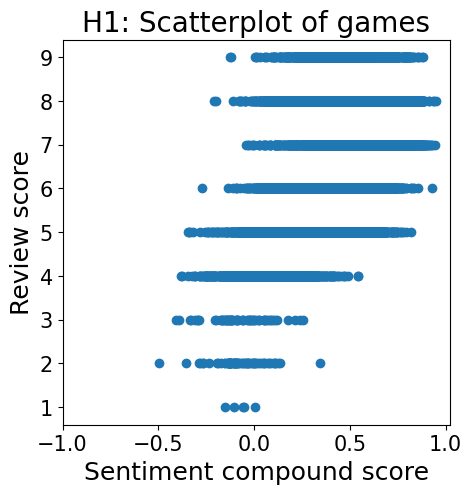

In [33]:
plt.figure(figsize=(5,5))
plt.title("H1: Scatterplot of games", fontsize=20)
plt.scatter(df_games['sent.mean_comp'], df_games['review_score'])
plt.xlabel("Sentiment compound score", fontsize=18)
plt.ylabel("Review score", fontsize=18)
plt.xticks(np.arange(-1.0, 1.01, 0.5), fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## 4.2 Hypothesis H2

> H2: There is a positive correlation between the _**sentiment of each review**_ and its perceived _**helpfulness**_ by the community.

Helpfulness = Weighted vote score of the review

In [50]:
H2_coeff, H2_p_value = stats.pearsonr(abs(df_reviews['sent.comp']), df_reviews['weighted_vote_score'])
print("Correlation:", H2_coeff)
print("P-value:", H2_p_value)

Correlation: 0.06897808371481899
P-value: 0.0


In [64]:
test_values = {'sample_count':[], 'coefficents':[], 'p_values':[]}
for i in [10, 100, 1_000, 10_000, 100_000, 1_000_000]:
    df_test = df_reviews.loc[0:i,:]
    coeff, p_value = stats.pearsonr(abs(df_test['sent.comp']), df_test['weighted_vote_score'])
    test_values['sample_count'].append(i)
    test_values['coefficents'].append(coeff)
    test_values['p_values'].append(p_value)
display(pd.DataFrame(test_values))

,sample_count,coefficents,p_values
0,10,0.097165,7.762537e-01
1,100,0.059177,5.566430e-01
2,1000,-0.048116,1.281835e-01
3,10000,0.018357,6.639646e-02
4,100000,0.053679,1.028059e-64
5,1000000,0.096381,0.000000e+00


### Scatterplot

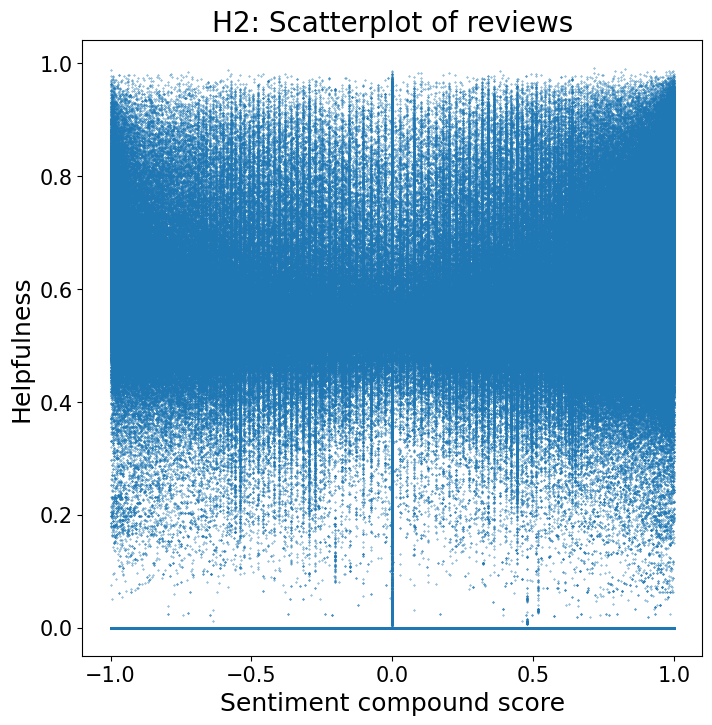

In [43]:
plt.figure(figsize=(8,8))
plt.title("H2: Scatterplot of reviews", fontsize=20)
plt.scatter(df_reviews['sent.comp'], df_reviews['weighted_vote_score'], s=0.1)
plt.xlabel("Sentiment compound score", fontsize=18)
plt.ylabel("Helpfulness", fontsize=18)
plt.xticks(np.arange(-1.0, 1.01, 0.5), fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Same as before. We investigate how fast the p-value drops with increased sample size.

### Distribution of the sentiment compound score values

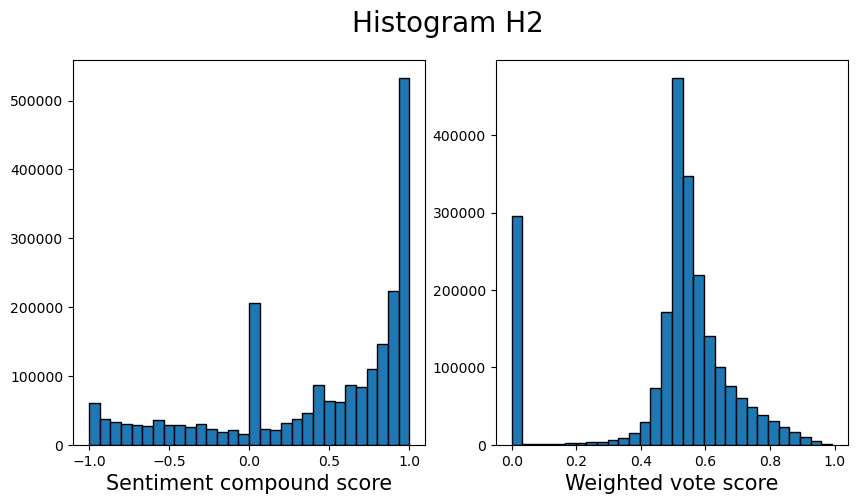

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle("Histogram H2", fontsize=20)
ax1.hist(df_reviews['sent.comp'], bins=30, edgecolor='black')
ax1.set_xlabel("Sentiment compound score", fontsize=15)
ax2.hist(df_reviews['weighted_vote_score'], bins=30, edgecolor='black')
ax2.set_xlabel("Weighted vote score", fontsize=15)
plt.show()

### Bootstrapping

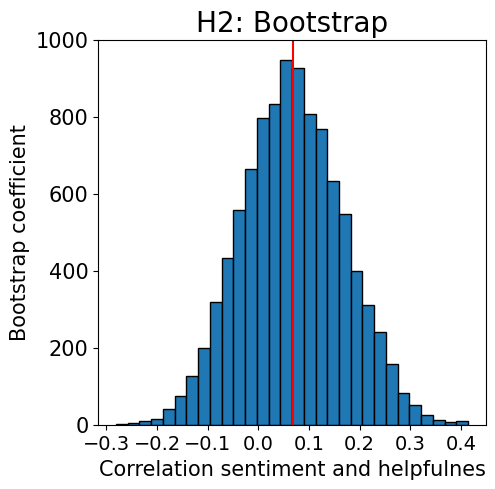

Interval [-0.2812982398067131, 0.4145619644455468]


In [63]:
coefficents = []
for _ in range(10_000):
    sampled = df_reviews.sample(100, replace=True)
    coeff, p_value = stats.pearsonr(abs(sampled['sent.comp']), sampled['weighted_vote_score'])
    coefficents.append(coeff)
coefficents = np.array(coefficents)

plt.figure(figsize=(5,5))
plt.hist(coefficents, bins=30, edgecolor='black')
plt.title("H2: Bootstrap", fontsize=20)
plt.xlabel("Correlation sentiment and helpfulnes", fontsize=15)
plt.ylabel("Bootstrap coefficient", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(np.arange(0,1001, 200),fontsize=15)
plt.axvline(H2_coeff, color="red")
plt.show()

print(f"Interval [{min(coefficents)}, {max(coefficents)}]")

## 4.3 Hypothesis H3

> H3: Reviews that _**recommend**_ the game are more _**positive in their sentiment**_ than reviews that do _**not recommend**_ the game.

#### Reviews that recommend the game

In [78]:
df_votedup_reviews = df_reviews.loc[df_reviews['voted_up'] == True, ['appid', 'reviewid' ,'sent.comp', 'text']]
df_votedup_reviews.reset_index(inplace=True)
mean_sent_recommended = df_votedup_reviews['sent.comp'].mean()
group_recommend = df_votedup_reviews['sent.comp'].to_list()

print("recommending reviews:", df_votedup_reviews.shape[0])
print("mean positive sentiment:", mean_sent_recommended)
display(df_votedup_reviews)

recommending reviews: 1634277
mean positive sentiment: 0.5662239961769027


,index,appid,reviewid,sent.comp,text
0,0,10,0,-0.2584,Sometimes you will never know the value of a m...
1,1,10,1,0.9442,One of the best games of our childhood. I don'...
2,2,10,2,0.3400,Players who's still play this game:\n⣿⣿⣿⣿⣿⣿⣿⣿⡿...
3,3,10,3,0.3612,joining a server is like russian roulette
4,4,10,4,0.3400,people who still play this game\n⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⠛⠛...
...,...,...,...,...,...
1634272,2204495,2222200,95,0.6696,I Love this game!
1634273,2204496,2222200,96,0.9105,It was really nice to discover the different c...
1634274,2204497,2222200,97,0.8614,very fun! keep up the great work tom!!
1634275,2204498,2222200,98,0.8268,Amazing game! It's got a lot of funny enemies ...


#### Reviews that DO NOT recommend the game

In [79]:
df_voteddown_reviews = df_reviews.loc[df_reviews['voted_up'] == False, ['appid', 'reviewid', 'sent.comp', 'text']]
mean_sent_not_recommended = df_voteddown_reviews['sent.comp'].mean()
group_not_recommend = df_voteddown_reviews['sent.comp'].to_list()

print("not recommending reviews:", df_voteddown_reviews.shape[0])
print("mean positive sentiment:", mean_sent_not_recommended)
display(df_voteddown_reviews)

not recommending reviews: 570223
mean positive sentiment: 0.0077287811961285315


,appid,reviewid,sent.comp,text
97,10,97,0.0000,Лагает..
109,20,9,0.9408,The game is chaotic fun but there's only like ...
114,20,14,-0.6486,"Gameplay's alright, the admins suck dick like ..."
157,20,57,0.9906,Here you will see why I love Team Fortress Cla...
203,30,3,-0.5859,some 30 year old basement dwellers got mad at ...
...,...,...,...,...
2204413,2222200,13,-0.2982,You know the combat system from Final Fantasy ...
2204444,2222200,44,0.0000,the game is not worth the money. while the gam...
2204445,2222200,45,-0.2982,You know the combat system from Final Fantasy ...
2204476,2222200,76,0.0000,the game is not worth the money. while the gam...


#### Outliers

In [81]:
def extract_outliers(df:pd.DataFrame, column:str) -> pd.DataFrame:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    return df[((df[column]<(q1-1.5*iqr)) | (df[column]>(q3+1.5*iqr)))]

df_outliers_down = extract_outliers(df_voteddown_reviews, 'sent.comp')
df_outliers_up = extract_outliers(df_votedup_reviews, 'sent.comp')

print("Num voted down outliers:", df_outliers_down.shape[0])
print("Num voted up outliers:", df_outliers_up.shape[0])

Num voted down outliers: 0
Num voted up outliers: 75704


#### Boxplots

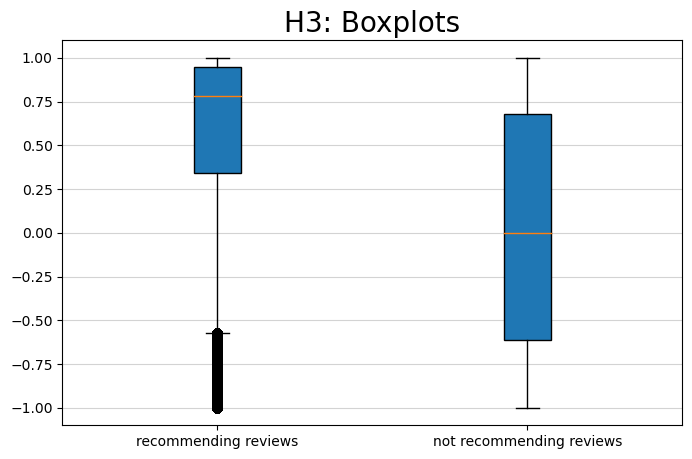

In [86]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.yaxis.grid(True, linestyle='-', color='lightgrey')
ax.boxplot([
    df_votedup_reviews['sent.comp'].tolist(), 
    df_voteddown_reviews['sent.comp'].tolist()], 
    patch_artist=True)
ax.set_xticklabels(['recommending reviews', 'not recommending reviews'])
ax.set_title("H3: Boxplots", fontsize=20)
plt.show()

#### Check the distributions of both groups

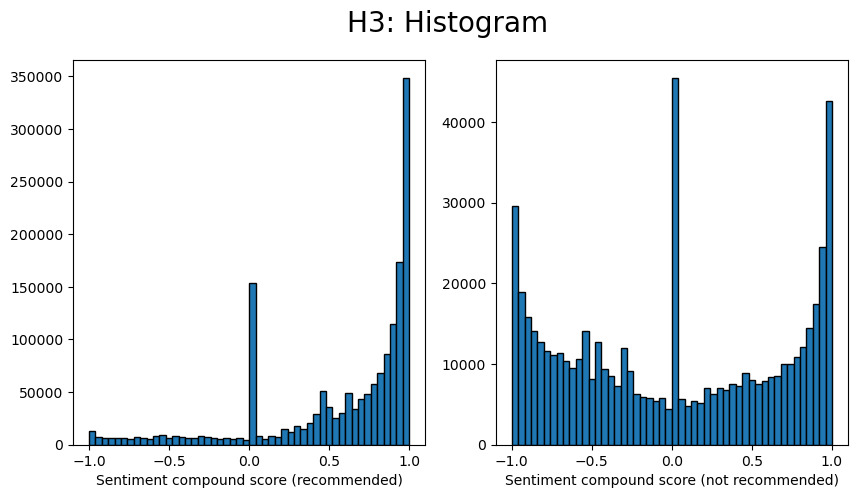

In [88]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle("H3: Histogram", fontsize=20)
ax1.hist(df_votedup_reviews['sent.comp'], bins=50, edgecolor='black')
ax1.set_xlabel("Sentiment compound score (recommended)")
ax2.hist(df_voteddown_reviews['sent.comp'], bins=50, edgecolor='black')
ax2.set_xlabel("Sentiment compound score (not recommended)")
plt.show()

#### Levene-Test
with a Levene-Test check for:
* Homoskedasticity (Standard deviation of both groups are 'equal') OR 
* Heteroskedasticity ('Different' standard deviations)

In [89]:
statistic, p_value = stats.levene(group_recommend, group_not_recommend, center='mean')
significant = p_value < 0.05
equal_variances = not significant
if not significant:
    print("Variances are not significant different => Homoskedasticity")
else:
    print("Variances are significant different => Heteroskedasticity")

Variances are significant different => Heteroskedasticity


#### t-Test

In [90]:
statistic, p_value = stats.ttest_ind(a=group_recommend, b=group_not_recommend, equal_var=equal_variances)
print("Statistic:", statistic)
print("P-value:", p_value)

Statistic: 576.92297459296
P-value: 0.0


#### Bootstrap

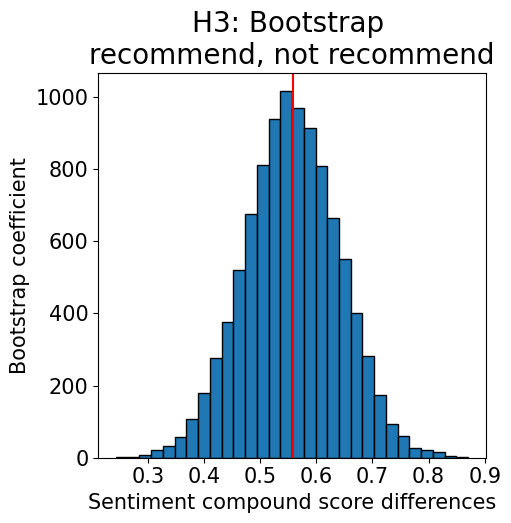

Interval [0.243311, 0.870495]


In [97]:
diffs = []
for _ in range(10_000):
    sampled_votedup = df_votedup_reviews.sample(100, replace=True)
    sampled_voteddown = df_voteddown_reviews.sample(100, replace=True)
    sampled_diff = sampled_votedup['sent.comp'].mean() - sampled_voteddown['sent.comp'].mean()
    diffs.append(sampled_diff)
diffs = np.array(diffs)

H3_diff = mean_sent_recommended - mean_sent_not_recommended

plt.figure(figsize=(5,5))
plt.hist(diffs, bins=30, edgecolor='black')
plt.title("H3: Bootstrap \nrecommend, not recommend", fontsize=20)
plt.xlabel("Sentiment compound score differences", fontsize=15)
plt.ylabel("Bootstrap coefficient", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(H3_diff, color="red")
plt.show()

print(f"Interval [{min(diffs)}, {max(diffs)}]")

***
[< back to contents](####contents-of-this-notebook)
### 5 Conclusions

In [183]:
print("H1: There is a positive correlation between the sentiment of the reviews and the review-score of each game.\n"
    f" => {H1_coeff}, {H1_coeff > 0}\n\n"
    "H2: There is a positive correlation between the sentiment of each review and its perceived helpfulness by the community.\n"
    f" => {H2_coeff}, {H2_coeff > 0}\n\n"
    "H3: Reviews that recommend the game are more positive in their sentiment than reviews that do not recommend the game.\n"
    f" => {mean_sent_recommended > mean_sent_not_recommended}")

H1: There is a positive correlation between the sentiment of the reviews and the review-score of each game.
 => 0.5215793161444982, True

H2: There is a positive correlation between the sentiment of each review and its perceived helpfulness by the community.
 => 0.06897808371481899, True

H3: Reviews that recommend the game are more positive in their sentiment than reviews that do not recommend the game.
 => True


[< back to contents](####contents-of-this-notebook)
***
~ You've come to the end of this project. We hope it was interesting to look into and you learned something about human behaviour. :) 

[^ go to top](#project-sentiment-analysis-on-steam-games)